lambdaq: [[9.60765453 0.18114394]]
run FFVB Time:  17.14611555099998
maxLB:  -32.32060451482579
Iterations:  694


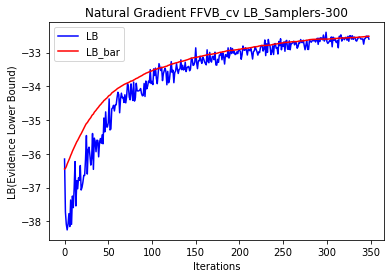

In [5]:
#Algorithm6 FFVB Natural Gradient with control variate for univariate gaussian CODE Reference from VBayesLab
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.special import psi
import math
import timeit
start = timeit.default_timer()

y = [11, 12, 8, 10, 9, 8, 9, 10, 13, 7] # data
n = len(y)
#===========================
d = 2
S = 300  #number of Monte Carlo samples

eps0 = 0.001
momentum_weight = 0.9
max_iter = 2000
patience_max = 20
tau_threshold = max_iter/2
t_w = 50
#hyperparameter
mu_hp = 0
sigma2_hp = 10

lambdaq = np.array([np.mean(y),1.5]).reshape(1,2)# initial lambdaq
lambda_best = lambdaq

#function h_lambda_fun
def h_lambda_fun(y,mu,mu_hp,sigma2_hp,mu_mu,sigma2_mu):
    log_p_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_hp)-(mu-mu_hp)**2/2/sigma2_hp
    log_q_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_mu)-(mu-mu_mu)**2/2/sigma2_mu
    llh = -n/2*np.log(2*np.pi)-1/2*sum((y-mu)**2)
    return log_p_mu+llh-log_q_mu

mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
h_lambda = np.zeros((S,1))#  function h_lambda
grad_log_q_lambda = np.zeros((S,d))
grad_log_q_times_h = np.zeros((S,d))
for s in range(S):
    mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
    grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2]).reshape(1,2)
    h_lambda[s] = h_lambda_fun(y,mu,mu_hp,sigma2_hp,mu_mu,sigma2_mu)    
    grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]

cv = np.zeros((1,d))# control variate
for i in range(d):
    aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
    cv[0,i] = aa[0,1]/aa[1,1]
#print("CV-control variate: " ,cv)
grad_LB1= np.mean(grad_log_q_times_h[:,0])
grad_LB2= np.mean(grad_log_q_times_h[:,1])
grad_LB_nat =np.array([grad_LB1,grad_LB2]).reshape(1,2)
grad_LB_bar = grad_LB_nat

iter_ = 1
stop = False
LB = np.array([-1e3 for i in range(2000)])
LB_bar = np.array([-1e3 for i in range(2000)])
patience = 0  
#print(LB,LB_bar.shape)
while not stop:
    mu_mu = lambdaq[0,0]
    sigma2_mu = lambdaq[0,1]
    h_lambda = np.zeros((S,1))# function h_lambda
    grad_log_q_lambda = np.zeros((S,d))
    grad_log_q_times_h = np.zeros((S,d))
    grad_log_q_times_h_cv = np.zeros((S,d))
    for s in range(S):
        mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
        grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2]).reshape(1,2)
        h_lambda[s] = h_lambda_fun(y,mu,mu_hp,sigma2_hp,mu_mu,sigma2_mu)    
        grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]
        grad_log_q_times_h_cv[s,:] = grad_log_q_lambda[s,:]*(h_lambda[s]-cv)
    cv = np.zeros((1,d))# control variate
    for i in range(d):
        aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
        cv[0,i] = aa[0,1]/aa[1,1]
        
    grad_LB1= np.mean(grad_log_q_times_h_cv[:,0])
    grad_LB2= np.mean(grad_log_q_times_h_cv[:,1])
    grad_LB =np.array([grad_LB1,grad_LB2]).reshape(1,2)
   
    grad_LB_nat = np.array([sigma2_mu*grad_LB[0,0],2*sigma2_mu**2*grad_LB[0,1]])
    grad_LB_bar = momentum_weight*grad_LB_bar+(1-momentum_weight)*grad_LB_nat

    if iter_>=tau_threshold:
        stepsize = eps0*tau_threshold/iter_
    else:
        stepsize = eps0
       
    lambdaq = lambdaq+stepsize*grad_LB_bar

    LB[iter_] = np.mean(h_lambda)

    if iter_>=t_w:
        LB_bar[iter_-t_w+1] = np.mean(LB[iter_-t_w+1:iter_])

    if iter_>t_w:
        if LB_bar[iter_-t_w+1]>=max(LB_bar):
            lambda_best = lambdaq
            patience = 0
        else:
            patience = patience+1

    if patience>patience_max or iter_>max_iter:
        stop = True
    iter_ = iter_+1

lambdaq = lambda_best
mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
print("lambdaq:",lambdaq)
stop = timeit.default_timer()
print('run FFVB Time: ', stop - start)
print('maxLB: ',max(LB_bar))
print('Iterations: ',iter_)
plt.plot(LB[1:350],color="b",label="LB")
plt.plot(LB_bar[1:350],color="r",label="LB_bar")
plt.title("Natural Gradient FFVB_cv LB_Samplers-300")
plt.ylabel("LB(Evidence Lower Bound)")
plt.xlabel("Iterations")
plt.legend()
plt.show()